In [1]:
import sys
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

d:\School Files\Artificial Intelligence\Pytorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and Preprocessing Scientific Abstracts

In [2]:
# Directory of research articles
astronomy_articles="./raw_scrape/astronomy.json"
psychology_articles="./raw_scrape/psychology.json"
sociology_articles="./raw_scrape/sociology.json"

# Reading the JSON files into a pandas dataframe
df_astro = pd.read_json(astronomy_articles) 
df_astro.insert(0, "category", "astronomy") # Adding a category column with value astronomy 
df_socio = pd.read_json(sociology_articles)
df_socio.insert(0, "category", "sociology") # Adding a category column with value sociology
df_psycho = pd.read_json(psychology_articles)
df_psycho.insert(0, "category", "psychology") # Adding a category column with value psychology

df = pd.concat([df_astro, df_socio, df_psycho], axis=0, ignore_index=True) # Combining all the dataframes
df = df.rename(columns={0 : "article"}) # Changing the name of the column that contains the articles from 0 to "article"
print(df.groupby("category").describe()) # There are some duplicate articles for reasons unknown. The scraping code ensured that no articles was taken twice unless the API has duplicates articles with different urls. However, each field has above 300 articles
df = df.drop_duplicates(subset="article", keep="first") # Keep the first occurrence of a duplicate and removing the second occurence
print(df.groupby("category").describe()) # There are some duplicate articles for reasons unknown. The scraping code ensured that no articles was taken twice unless the API has duplicates articles with different urls. However, each field has above 300 articles
df['category_num'] = df['category'].map({ # Adding a new column called category_num that represents the field of the article in numerical form. 
    'astronomy': 0, # Maps all astronomy papers to 0
    'sociology': 1, # Maps all sociology papers to 1
    'psychology': 2 # Maps all psychology papers to 2
})
df.head()

           article                                                            \
             count unique                                                top   
category                                                                       
astronomy      400    388  The Nearby Evolved Stars Survey (NESS) is a vo...   
psychology     397    381  Alcohol has been associated with violent crime...   
sociology      400    381  \n            In the thirty years since Massey...   

                 
           freq  
category         
astronomy     2  
psychology    2  
sociology     2  
           article                                                            \
             count unique                                                top   
category                                                                       
astronomy      388    388  For the past fifty years of space exploration,...   
psychology     381    381  Drawing on ecosystem theory, which is based on...   
sociology  

,category,article,category_num
0,astronomy,"For the past fifty years of space exploration,...",0
1,astronomy,"Context. The formation mechanisms of stellar, ...",0
2,astronomy,Context. Small planets located at the lower mo...,0
3,astronomy,We identify stellar structures in the PHANGS s...,0
4,astronomy,▪ Abstract We review the research on a wide ...,0


Creating a custom dataset class to preprocess text from human readable language to tokens that BERT uses

In [3]:
"""
Defines a custom dataset class for text classification tasks. 
Prepares raw text data from the pandas dataframe into the format that BERT requires.

Format that BERT requires:
Input ID: Integers that represent words in tokens based on a tokenization vocabulary for bert-base-uncased.
Attention Mask: A binary list that separates real tokens from padded tokens (Padded tokens are tokens used to make input sequences the same length == 512, if a sentence has less than 512 tokens then padded tokens are added but they do not hold any relevant information so model needs to know these tokens can be ignored).
Label: Convert the label encoding into torch tensors.

Inherits from PyTorch's `Dataset` class.

Attributes:
    texts (Pandas df) : Dataframe that contains all the scientific abstracts in strings.
    labels (Pandas df) : Dataframe that contains all the scientific abstract labels in string (should be the same length as texts).
    tokenizer (BERT Tokenizer instance) : BERT tokenizing object that tokenizes the scientific abstracts based on a tokenization vocabulary.
    max_length (int): Maximum length of the input sequences (set to 512 for BERT, as it can handle up to 512 tokens).
"""
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # max length is set to 512 since BERT can only handle up to 512 tokens

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True) #Truncation = True means that extracts that creates more than 512 tokens are cut off
        return {
                'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(), 
                'label': torch.tensor(label)
                }

Creating the machine learning model which uses BERT and a classifying layer

In [4]:
"""
Creating the machine learning model based on BERT with a classifying layer.

Inherits nn.Module from PyTorch to define the model's architecture and forward pass.

Attributes:
    bert_model_name (str) : Name of pre-trained BERT model to be used ex."bert-base-uncased".
    num_classes (int) : Number of output classes (3 in this case which is Astronomy, Psychology, and Sociology).
"""
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name) # Loads a pretrained BERT model
        self.dropout = nn.Dropout(0.1) # Creates a dropout layer that is connected to the output of the BERT layer and the input of the classifying layer. 1 out of 10 neurons are randomly turned off to prevent overfitting 
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) # A linear neural network layer with input size of 768 neurons (size of BERT's hidden layer) and output size equal to 3 (number of class for labelling)
    """
    Handles the computation from tokenized sequences -> BERT Processing -> dropout -> and classification to one of the three classes.
    
    Attributes:
        input_ids (PyTorch tensor) : Tokenized and encoded IDs of the input text (abstract). Tokenized and encoded by BERT tokenizer.
        attention_mask (PyTorch tensor) : A mask returned by BERT Tokenizer to differentiate real tokens and padding tokens.
    """
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # Runs the input through BERT
        pooled_output = outputs.pooler_output # Extract the pooler_output from the outputs dict. pooler_output is a vector of fixed size 768 (number of neurons) that represents the sequence of IDs from the input
        x = self.dropout(pooled_output) # Applies dropout to the pooled output 
        logits = self.fc(x) # Passes BERT's output to the classifying head (after applying dropout) for classification. Returns logits which can be passed through a softmax function for probabilities of each output class
        return logits

Creating the training function to fine tune the machine learning model

In [5]:
"""
Training function to train a multi-layered machine learning model based on BERT's architecture

Attributes:
    model (nn.Module) : Model that will be trained.
    data_loader (DataLoader) : A PyTorch DataLoader object to supply batches of training data. DataLoader object contains tokenized and encoded sequences from BERT Tokenizer.
    optimizer (torch.optim.Optimizer) : Optimizer used to update the model's parameters based on the computed gradients.
    scheduler (torch.optim.lr_scheduler.LambdaLR) : Learning rate scheduler responsible for adjusting the learning rate during training. Learning rate decreases throughout training and this scheduler contains the predefined strategy to decrease the learning rate.
    device (str) : Specifies where the model and data will be moved to. Model, input, and labels should be processed on the same hardware. "cuda" for GPU and "cpu" for cpu.
"""
def train(model, data_loader, optimizer, scheduler, device):
    model.train() # Sets the model to training mode
    for batch_idx, batch in enumerate(data_loader): # Iterates sequence batches in data loader according to batch_size
        optimizer.zero_grad() # Zero the gradients from previous batch
        input_ids = batch['input_ids'].to(device) 
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['label'].to(device) # Moving the batch data to the specified device
        outputs = model(input_ids=input_ids, attention_mask=attention_mask) # Forward pass of batch data to obtain output (logits)
        loss = nn.CrossEntropyLoss()(outputs, labels) # calculate the loss between the output and the true labels 
        loss.backward() # Backpropagation to compute the gradient of the loss with respect to the model's current parameters. Gradients are stored as weights to be updated later. 
        optimizer.step() # Updates the model's parameters according to the calculated gradients during the backward pass
        scheduler.step() # Updates the learning rate 

        # Log the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
        progress = f"Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.8f}" # Display the current batch, loss, and learning rate
        sys.stdout.write("\r" + progress) # Dont print a new line but overlap, like a progress bar
        sys.stdout.flush()  
    print()

Creating the evaluation function to monitor the performance of the model

In [6]:
"""
Evaluation function to assess the performance of the model based on an evaluation set or training set. Calculates the loss, accuracy, precision, recall, f1-score for the given dataset. 

Attributes:
    model (nn.Module) : Trained PyTorch machine learning model to evaluate
    data_loader (DataLoader) : PyTorch DataLoader object that supplies data equal to batch_size for prediction
    device (str) : Specifies which hardware device to send the model and data to. 
"""
def evaluate(model, data_loader, device):
    model.eval() # Sets the model to evaluation mode
    predictions = [] # Initialize list for predictions
    actual_labels = [] # Initialize list for true labels
    total_loss = 0.0  # Variable to accumulate loss
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device) 
            labels = batch['label'].to(device) # Sending data batches to device
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) # Forward pass of the data through the model 
            logits = outputs  # Get the raw logits output from the model
            loss = nn.CrossEntropyLoss()(logits, labels)  # Calculate loss between prediction label and true label
            total_loss += loss.item()  # Accumulate loss for averaging
            
            _, preds = torch.max(logits, dim=1)  # Get predicted class indices based on the model's output logits. In this case, logits are not passed through a function like softmax because simply selecting the class with the maximum value from the logits tensor is sufficient. 
            predictions.extend(preds.cpu().tolist()) # Add prediction result to prediction list
            actual_labels.extend(labels.cpu().tolist()) # Add true label to true label list
    
    # Compute the average loss
    avg_loss = total_loss / len(data_loader)
    
    # Calculate accuracy and other classification metrics
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions) # calculates f1-score, precision, and recall per class

    return avg_loss, accuracy, report

Creating an early stopping class to stop fine tuning when validation loss stops improving (precaution to prevent overfitting)

In [7]:
"""
EarlyStopping class that monitors a validation metric per epoch and stops training early if validation metric does not improve after a certain number of epochs as specific by the patience value.
The class saves the model weight with the best validation metric. 

Attributes:
    patience (int): Number of consecutive epochs without improvement before training is stopped. 
    delta (float): Minimum change in validation metric to qualify as an improvement. 
    mode (str): Minimize (validation loss) or maximize (validation accuracy) of validation metric.
    verbose (bool): Show or hide information such as when validation metric improves or stopping counter increases. 
"""
class EarlyStopping:
    def __init__(self, patience=3, delta=0, mode='min', verbose=False):

        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_wts = None # save the weights of the best model

    def __call__(self, val_loss, model):
        """
        Call this method after each validation to check whether to stop the training.

        Attributes: 
            val_loss (float): The current validation loss.
            model (torch.nn.Module): The model being trained. The best model's weights will be saved. 
        """
        if self.best_score is None:
            self.best_score = val_loss
            self.save_best_model(model)
        elif (self.mode == 'min' and val_loss < self.best_score - self.delta) or \
             (self.mode == 'max' and val_loss > self.best_score + self.delta):
            self.best_score = val_loss
            self.save_best_model(model) # Saving the weight of the best model
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose: # If verbose is False (don't show information), the print statement will be omitted 
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_best_model(self, model):
        """
        Save the model weights.

        Arguments:
            model (nn.Module) : Weights from this model will be saved
        """
        self.best_model_wts = model.state_dict() # Saving the weights of the best model in best_model_wts attribute of EarlyStopping class object

    def restore_best_model(self, model):
        """
        Restore the model weights from the best epoch according to the validation metric

        Arguments: 
            model (nn.Module) : Weights from the best model will be loaded to this model
        """
        if self.best_model_wts is not None:
            model.load_state_dict(self.best_model_wts) # Loading the weights of the best model from best_model_wts attribute of EarlyStopping class object

Setting up parameters for the machine learning model

In [8]:
# Setting up model parameters
bert_model_name = 'bert-base-cased' # Base BERT model with 12 layers. Cased meaning the model distinguishes between lowercase and uppercase words which is important for scientific journals where preserving capitalization can bring important insight to domain specific knowledge
num_classes = 3 # 3 classification classes ("Astronomy", "Sociology", "Psychology")
max_length = 512 # 512 tokens for base BERT
batch_size = 16 # 16 is the perfect balance between memory costs, training time, and model performance
num_epochs = 30 # 30 epochs is excessive and risks overfitting but EarlyStopping class should prevent that 
learning_rate = 1e-5 # Quite low learning rate from the beginning because BERT is a powerful model for a simple NLP classifying task such as this where domain specific terminologies are very evident. Therefore, convergence should be quite quick and a low learning rate improves convergence and reduces instability

Fine tuning the model

In [9]:
#Initializing the folds
skf = StratifiedKFold(n_splits=5, random_state=4, shuffle=True) # Splits the dataset into 5 folds. Using StratifiedKFold so the distribution is equal across all classes. Astronomy papers make up 1/3, Psychology makes up 1/3, and finally Sociology makes up 1/3.
folds = skf.split(df["article"], df["category_num"]) # Splits the dataset into 4/5 training data and 1/5 testing data 

# Empty list to be used later to create the confusion matrix
true_labels_confusion = []
predicted_labels_confusion = []

for i, (fold_train, fold_test) in enumerate(folds, start=1):

    train_fold = df.iloc[fold_train] # Training fold
    test_fold = df.iloc[fold_test]  # Testing fold

    # Separating texts and label from training dataframe
    train_texts = train_fold["article"]
    train_labels = train_fold["category_num"] 

    # Splitting training data into training data (3/4) and evaluating data to be used for EarlyStopping (1/4)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25, random_state=4)

    # Turning it back into a dataframe
    train_texts = pd.DataFrame(train_texts)["article"]
    val_texts = pd.DataFrame(val_texts)["article"]
    train_labels = pd.DataFrame(train_labels)["category_num"]
    val_labels = pd.DataFrame(val_labels)["category_num"]

    # Separating texts and label from testing dataframe
    test_texts = test_fold["article"]
    test_labels = test_fold["category_num"]

    # Resetting index for all Dataframes
    train_texts = train_texts.reset_index(drop=True) 
    train_labels = train_labels.reset_index(drop=True) 
    val_texts = val_texts.reset_index(drop=True) 
    val_labels = val_labels.reset_index(drop=True) 
    test_texts = test_texts.reset_index(drop=True) 
    test_labels = test_labels.reset_index(drop=True) 

    # Setting up the device and model 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model = BERTClassifier(bert_model_name, num_classes).to(device)

    # Initializing tokenizer, dataset, and data loader
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Setting up optimizer and learning rate scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Setting up early stopping
    early_stopping = EarlyStopping(patience=5, mode="min", verbose=True) # Patience is quite high but learning rate is very low so it gives the model more time to possibly converge better. 

    print(f"Fold {i}" + "_"*100)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device) # Training the model per epoch
        val_loss, accuracy, report = evaluate(model, val_dataloader, device) # Evaluate the model at each epoch after training is finished
        print(f"Validation Accuracy: {accuracy:.4f} | Validation Loss: {val_loss:.4f}") # Printing the Accuracy and Loss based on the validation set
        print(report) # Printing the recall, precision, and f1 score
        early_stopping(val_loss, model) # Based on the validation loss and patience counter, determine whether training should stop at this epoch
        # If early stopping is triggered, exit training loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered. Stopping training at Epoch {epoch + 1}/{num_epochs}") 
            early_stopping.restore_best_model(model) # Training ends and the model with the best weight is restored to the current model
            break

    # Setup to assess performance of this fold's model on testing data
    # Set model to evaluation mode
    model.eval()

    # Lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    class_names=["Astronomy", "Sociology", "Psychology"]

    # Disable gradient calculations for faster inference
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device) # Putting all the batch data into the hardware device

            # Forward pass (Prediction), returns logits
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Uses the returned logits and puts it through a max function to find the class with the highest probability. The class with the highest probability is the prediction based on the input text
            _, preds = torch.max(outputs, dim=1)

            # Store results
            true_labels.extend(labels.cpu().tolist())  # Convert to list and store
            predicted_labels.extend(preds.cpu().tolist())  # Convert to list and store

    # Appending the true label and predicted label of this fold's model to a list outside of the loop to create an aggregated confusion matrix
    true_labels_confusion = true_labels_confusion + true_labels
    predicted_labels_confusion = predicted_labels_confusion + predicted_labels

    # Print classification report which contains the precision, recall, f1-score, and accuracy of this fold's model performance
    print(f"Performance report for fold {i}")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))
    if i == 4:
        torch.save(model.state_dict(), f"./models/bert_model_{i}") # Saving the 4th model into storage (4th model is arbitrary, there is no reason that I chose 4)

Fold 1____________________________________________________________________________________________________
Epoch 1/30
Batch 44/44, Loss: 0.0339, Learning Rate: 0.00001933
Validation Accuracy: 0.8913 | Validation Loss: 0.2884
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       0.75      0.99      0.85        74
           2       0.98      0.69      0.81        78

    accuracy                           0.89       230
   macro avg       0.91      0.89      0.89       230
weighted avg       0.91      0.89      0.89       230

Epoch 2/30
Batch 44/44, Loss: 0.0276, Learning Rate: 0.00001867
Validation Accuracy: 0.9652 | Validation Loss: 0.1026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       0.93      0.96      0.95        74
           2       0.96      0.94      0.95        78

    accuracy                           0.97       230
   m

Creating an aggregated confusion matrix based on the performance of the models in all 5 folds

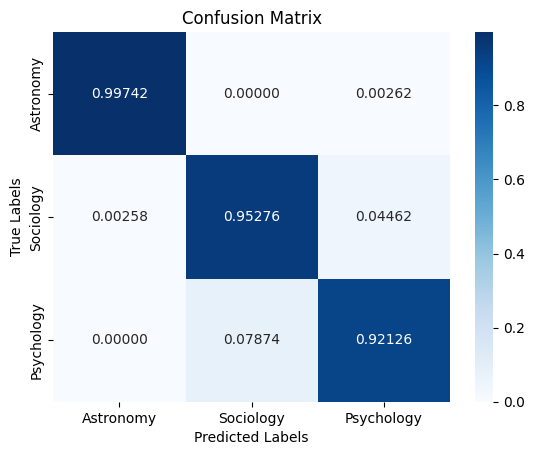

In [10]:
# Confusion Matrix
cm = confusion_matrix(true_labels_confusion, predicted_labels_confusion) # Creating the confusion matrix based on all the predicted labels across all 5 folds
cm_normalized = cm.astype('float') / cm.sum(axis=1) # Normalized by row
sns.heatmap(cm_normalized, annot=True, fmt='.5f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()